<a href="https://colab.research.google.com/github/sanya-mahajan/Curvetopia/blob/main/regular_polygon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

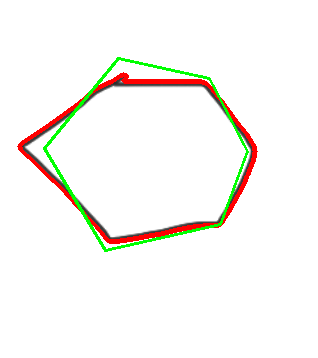

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def adjust_polygon_vertices(approx_polygon, num_sides):
    """Adjust the vertices of the polygon to form a regular polygon while retaining the original vertex positions as close as possible."""
    # Calculate the centroid of the original polygon
    M = cv2.moments(approx_polygon)
    if M['m00'] == 0:
        M['m00'] = 1  # Avoid division by zero
    center = (M['m10'] / M['m00'], M['m01'] / M['m00'])

    # Compute the radius as the average distance from the centroid to each vertex
    distances = [np.linalg.norm(np.array(vertex[0]) - np.array(center)) for vertex in approx_polygon]
    radius = np.mean(distances)

    # Calculate the angles of the original vertices relative to the centroid
    angles = [np.arctan2(vertex[0][1] - center[1], vertex[0][0] - center[0]) for vertex in approx_polygon]

    # Sort vertices by angle (in counterclockwise order)
    sorted_vertices = sorted(zip(angles, approx_polygon), key=lambda x: x[0])

    # Generate the new vertices for the regular polygon
    adjusted_polygon = []
    for i, (angle, original_vertex) in enumerate(sorted_vertices):
        new_vertex = (
            int(center[0] + radius * np.cos(angle)),
            int(center[1] + radius * np.sin(angle))
        )
        adjusted_polygon.append(new_vertex)

    return np.array(adjusted_polygon, np.int32)

# Load the image
image = cv2.imread('/content/bad hexagon.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur to the grayscale image to reduce noise
blurred = cv2.GaussianBlur(gray, (9, 9), 2)

# Use Canny Edge Detection
edges = cv2.Canny(blurred, 50, 150)

# Find contours in the edged image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# If there are no contours, exit
if not contours:
    print("No contours found")
else:
    # Find the largest contour based on area
    largest_contour = max(contours, key=cv2.contourArea)
    image = cv2.polylines(image, [largest_contour], True, (0, 0, 255), 3)
    # Approximate the contour to a polygon
    epsilon = 0.02 * cv2.arcLength(largest_contour, True)
    approx_polygon = cv2.approxPolyDP(largest_contour, epsilon, True)

    # Number of sides of the polygon
    num_sides = len(approx_polygon)

    # Adjust the vertices to form a regular polygon
    adjusted_polygon = adjust_polygon_vertices(approx_polygon, num_sides)

    # Draw the adjusted regular polygon on the original image
    adjusted_polygon = adjusted_polygon.reshape((-1, 1, 2))
    cv2.polylines(image, [adjusted_polygon], isClosed=True, color=(0, 255, 0), thickness=2)

    # Display the original image with the best-fit regular polygon
    cv2_imshow( image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()


In [ ]:
adjusted_polygon[0][0]

array([93, 87], dtype=int32)

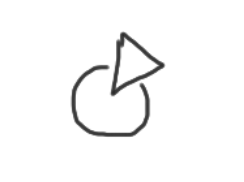

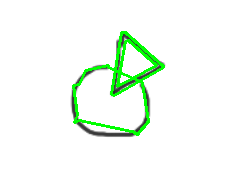

In [7]:
#handle occlusions

import cv2
import numpy as np
import math
from google.colab.patches import cv2_imshow

def adjust_polygon_vertices(approx_polygon, expected_sides):
    """Adjust and complete the polygon to form a regular polygon."""
    # Calculate the centroid of the polygon
    M = cv2.moments(approx_polygon)
    if M['m00'] == 0:
        M['m00'] = 1  # Avoid division by zero
    center = (M['m10'] / M['m00'], M['m01'] / M['m00'])

    # Compute the radius as the average distance from the centroid to each vertex
    distances = [np.linalg.norm(np.array(vertex[0]) - np.array(center)) for vertex in approx_polygon]
    radius = np.mean(distances)

    # Calculate the angles of the original vertices relative to the centroid
    angles = [np.arctan2(vertex[0][1] - center[1], vertex[0][0] - center[0]) for vertex in approx_polygon]

    # Sort vertices by angle (in counterclockwise order)
    sorted_vertices = sorted(zip(angles, approx_polygon), key=lambda x: x[0])

    # If fewer vertices than expected, estimate missing vertices
    if len(sorted_vertices) < expected_sides:
        adjusted_polygon = []
        angle_increment = 2 * np.pi / expected_sides

        for i in range(expected_sides):
            expected_angle = i * angle_increment
            closest_vertex = min(sorted_vertices, key=lambda x: abs(x[0] - expected_angle))

            if abs(closest_vertex[0] - expected_angle) > angle_increment / 2:
                # Missing vertex, estimate its position
                new_vertex = (
                    int(center[0] + radius * np.cos(expected_angle)),
                    int(center[1] + radius * np.sin(expected_angle))
                )
                adjusted_polygon.append(new_vertex)
            else:
                # Use the closest existing vertex
                adjusted_polygon.append(tuple(closest_vertex[1][0]))

        return np.array(adjusted_polygon, np.int32)
    else:
        return np.array([v[1] for v in sorted_vertices], np.int32)

# Example usage with the image processing pipeline
# Load the image
image = cv2.imread('/content/occ.png')
cv2_imshow(image)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Preprocess the image
blurred = cv2.GaussianBlur(gray, (9, 9), 2)
edges = cv2.Canny(blurred, 50, 150)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for contour in contours:
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx_polygon = cv2.approxPolyDP(contour, epsilon, True)


    expected_sides = 6

    # adjust and complete the polygon
    adjusted_polygon = adjust_polygon_vertices(approx_polygon, expected_sides)

    # Draw the completed polygon
    adjusted_polygon = adjusted_polygon.reshape((-1, 1, 2))
    cv2.polylines(image, [adjusted_polygon], isClosed=True, color=(0, 255, 0), thickness=2)

cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()
